### Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.graphics.api import abline_plot
    
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer

from sklearn.feature_selection import RFE, RFECV, SelectFromModel

from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance

import sklearn
print(sklearn.__version__)

1.3.1


### Поиск лучшей модели

#### Загрузка тренировочных данных

In [2]:
path_train = 'train_house_B.csv'

Задача - предсказать целевую переменную price.

In [3]:
data = pd.read_csv(path_train)

data.tail(5)

,price,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,27,28
403,3360000,-0.091662,0.593876,-0.087882,-2.465344,0.077307,0.151482,1.452151,1.772175,-1.264971,...,-0.141322,-0.554035,1.403419,-0.570187,0.454355,-0.805741,1.378217,1.200306,-0.679063,1.307431
404,5950000,-1.406286,0.179794,0.640850,0.405623,-0.126718,-0.975186,-1.028510,0.203867,-1.190658,...,-0.141322,1.804941,0.047278,-0.570187,-1.037904,1.517692,-0.929397,0.960546,-0.679063,-0.478408
405,3675000,-0.091662,1.099966,0.225750,-2.465344,-0.716123,-0.534316,-0.090348,1.151380,1.631097,...,-0.141322,-0.554035,-1.308863,-0.570187,0.477182,-0.805741,-0.929397,-1.512245,-0.679063,1.307431
406,7455000,1.222962,1.498909,-0.392289,0.405623,-0.126718,-0.024866,1.484438,-1.233671,-0.469048,...,-0.141322,-0.554035,0.047278,1.421812,0.407275,0.355976,0.224410,-1.477806,-0.679063,-0.478408
407,4900000,-0.091662,-0.280655,-0.991879,0.405623,-0.126718,-0.024866,-1.359317,-1.582810,-0.075905,...,-0.141322,-0.554035,0.047278,-0.570187,-0.612298,-0.805741,0.224410,0.634746,1.472618,-0.478408


#### Первичный анализ

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   408 non-null    int64  
 1   0       408 non-null    float64
 2   1       408 non-null    float64
 3   2       408 non-null    float64
 4   3       408 non-null    float64
 5   4       408 non-null    float64
 6   5       408 non-null    float64
 7   6       408 non-null    float64
 8   7       408 non-null    float64
 9   8       408 non-null    float64
 10  9       408 non-null    float64
 11  10      408 non-null    float64
 12  11      408 non-null    float64
 13  12      408 non-null    float64
 14  13      408 non-null    float64
 15  14      408 non-null    float64
 16  15      408 non-null    float64
 17  16      408 non-null    float64
 18  17      408 non-null    float64
 19  18      408 non-null    float64
 20  19      408 non-null    float64
 21  20      408 non-null    float64
 22  21

In [5]:
data.duplicated().sum()

0

- В данных отсутствуют дублированные строки
- В данных отсутствуют пропущенные значения
- Данные стандартизированы
- В данных есть мультиколлинеарные и шумящие признаки

#### Деление на тренировочную и проверочную часть

In [6]:
X = data.drop(columns = ['price'])
y = data.loc[:,'price'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25)

cv = ShuffleSplit(n_splits = 3, test_size = 0.3)

In [11]:
print(f"X_train {X_train.shape}   y_train {y_train.shape}   X_test {X_test.shape}   y_test {y_test.shape}\n")

X_train (306, 29)   y_train (306,)   X_test (102, 29)   y_test (102,)



Будем использовать метрику MAPE

In [14]:
scoring = 'neg_mean_absolute_percentage_error'

### Базовые модели

Попробуем прогнать модели со всеми признаками

In [12]:
def plot_2_error(y_true, y_predicted):
    
    residuals = (y_true - y_predicted)/y_predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    
    if abs(max(residuals)) > abs(min(residuals)):
        max_idx = list(residuals).index(max(residuals))
    else:
        max_idx = list(residuals).index(min(residuals))
    max_true, max_pred = y_true[max_idx], y_predicted[max_idx]
    
    print("Max Error:", "{:,.0f}".format(max_error))
    
    sns.set_style('white')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax[0].scatter(y_predicted, y_true, color="black", alpha=0.25)
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    #ax[0].vlines(x=max_pred, ymin=max_error, ymax=2*max_true-max_error, 
    #             color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    #ax[0].legend()

    ax[1].scatter(y_predicted, residuals, color="red", alpha=0.25)
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(y_predicted), xmax=np.max(y_predicted))
    ax[1].legend()

#### Регрессия Лассо

In [33]:
model = Lasso(alpha = 50)
model.fit(X_train, y_train)

dropped = X_train.columns.values[model.coef_ == 0]

print(f"mape на проверочном наборе: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.4f}")
print("mape на кроссвалидации:",
      f'{-1*cross_val_score(model, X_train, y_train, cv = cv, scoring = scoring).round(4)}'.replace("[", "").replace("]", ""))

mape на проверочном наборе: 0.1618
mape на кроссвалидации: 0.2289 0.2058 0.1766


In [21]:
print(f"выброшенные признаки:\n{X_train.columns.values[model.coef_ == 0]}\n".replace("[", "").replace("]", ""))
print(f"оставленные признаки:\n{X_train.columns.values[model.coef_ != 0]}\n".replace("[", "").replace("]", ""))

выброшенные признаки:
'10'

оставленные признаки:
'0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'



Max Error: 1


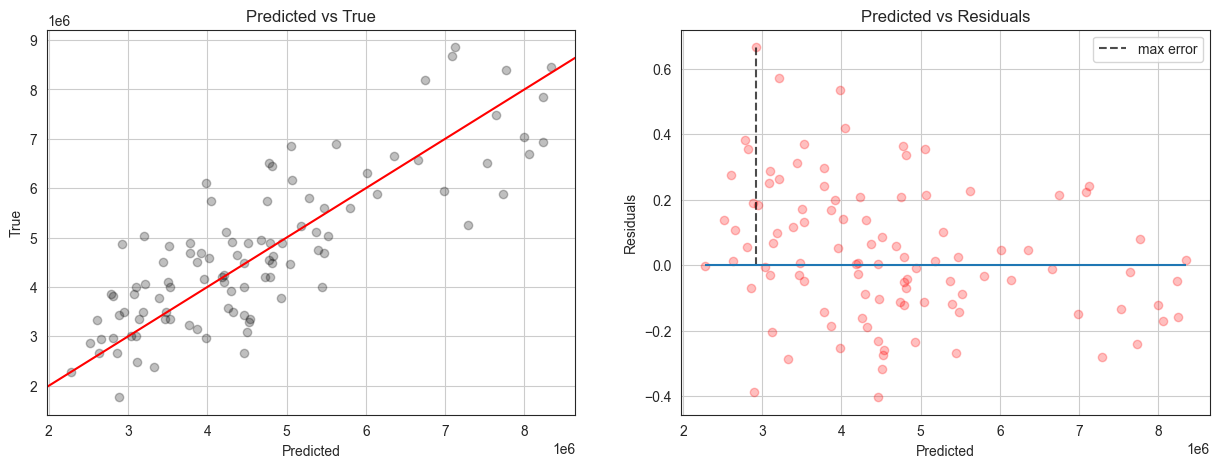

In [22]:
plot_2_error(y_test, model.predict(X_test))

#### Машина опорных векторов

In [31]:
model = SVR(kernel = 'linear')
model.fit(X_train, y_train)

print(f"mape на проверочном наборе: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.4f}")
print("mape на кроссвалидации:",
      f'{-1*cross_val_score(model, X_train, y_train, cv = cv, scoring = scoring).round(4)}'.replace("[", "").replace("]", ""))

mape на проверочном наборе: 0.2618
mape на кроссвалидации: 0.283  0.3113 0.3118


Max Error: 1


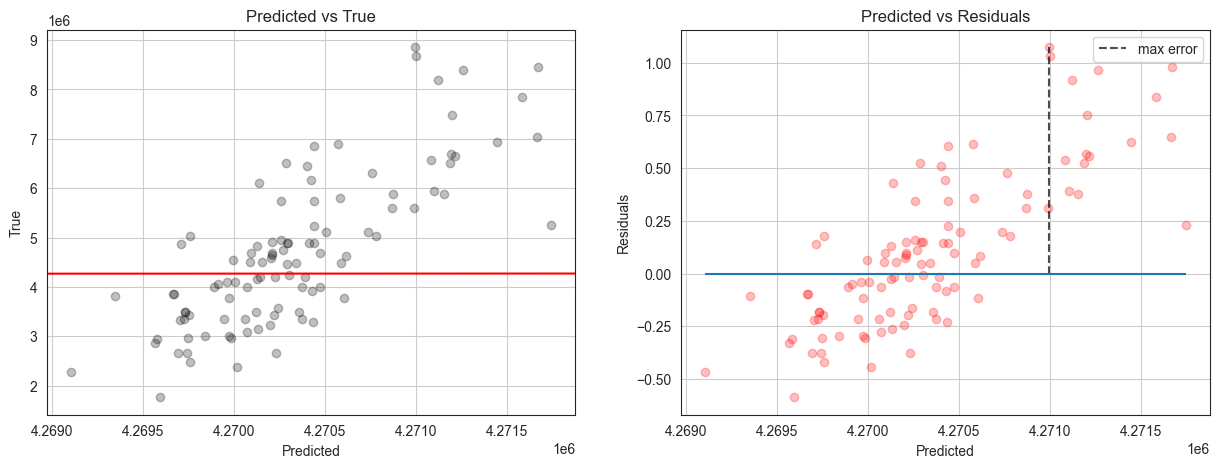

In [32]:
plot_2_error(y_test, model.predict(X_test))

#### Случайный лес

In [34]:
model = RandomForestRegressor(n_jobs = -1)
model.fit(X_train, y_train)

print(f"mape на проверочном наборе: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.4f}")
print("mape на кроссвалидации:",
      f'{-1*cross_val_score(model, X_train, y_train, cv = cv, scoring = scoring).round(4)}'.replace("[", "").replace("]", ""))

mape на проверочном наборе: 0.1704
mape на кроссвалидации: 0.2185 0.1856 0.1967


Max Error: 1


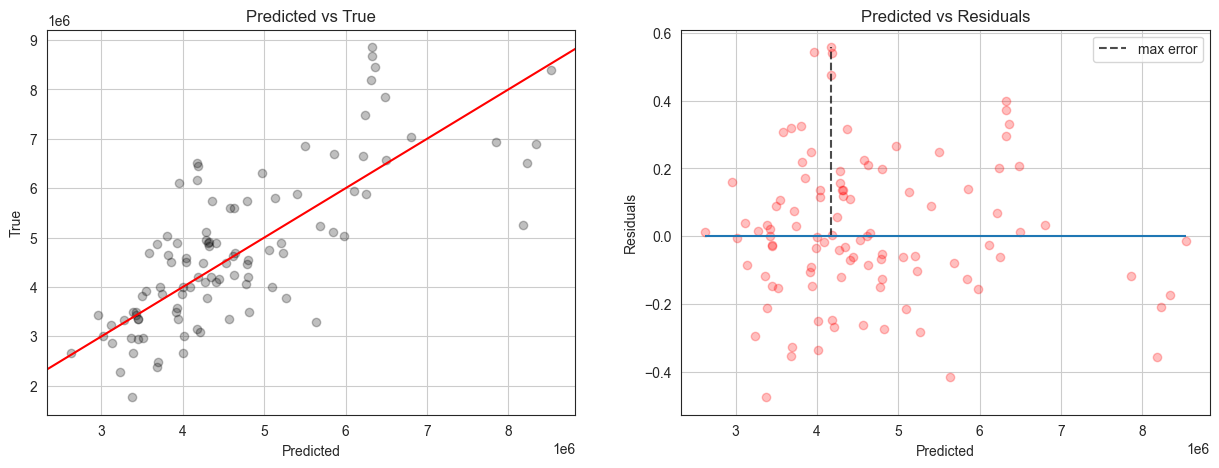

In [35]:
plot_2_error(y_test, model.predict(X_test))

Регрессия Лассо выбросила всего 1 признак. В целом модели сработали не очень хорошо из-за того, что есть шумящие или мультиколлинеарные признаки. Будем их искать.

### Отбор признаков

In [36]:
model_rf = RandomForestRegressor(n_jobs = -1)
model_svm = SVR(kernel = 'linear')

#### Отбор признаков по важности на основе модели

форма обуч набора X: (408, 29)
форма обуч набора X median: (408, 29)


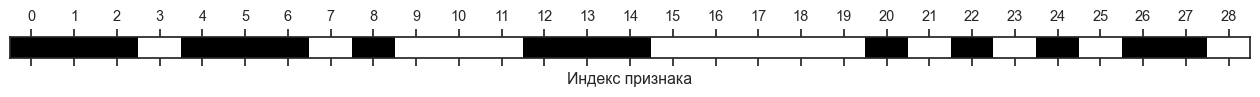

In [58]:
select = SelectFromModel(
    model_rf,
    threshold="median",
    max_features = None)

select.fit(X, y)
X_train_med = select.transform(X)
print("форма обуч набора X: {}".format(X.shape))
print("форма обуч набора X median: {}".format(X.shape))

mask = select.get_support()
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");
plt.show();

форма обуч набора X: (408, 29)
форма обуч набора X median: (408, 29)


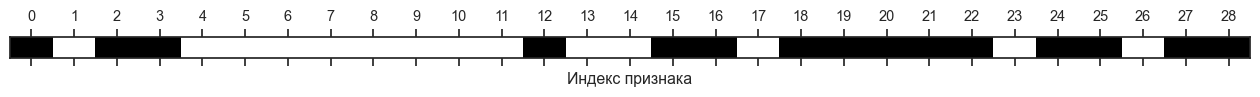

In [59]:
select = SelectFromModel(
    model_svm,
    threshold="median",
    max_features = None)

select.fit(X, y)
X_train_med = select.transform(X)
print("форма обуч набора X: {}".format(X.shape))
print("форма обуч набора X median: {}".format(X.shape))

mask = select.get_support()
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");
plt.show();

Для случайного леса: 0, 1, 2, 4, 5, 6, 8, 12, 13, 14, 20, 22, 24, 26, 27

Для машины: 0, 2, 3, 12, 15, 16, 18, 19, 20, 21, 22, 24, 25, 27, 28

#### Корреляционная матрица Спирмена и иерархическая кластеризация ранговых корреляций

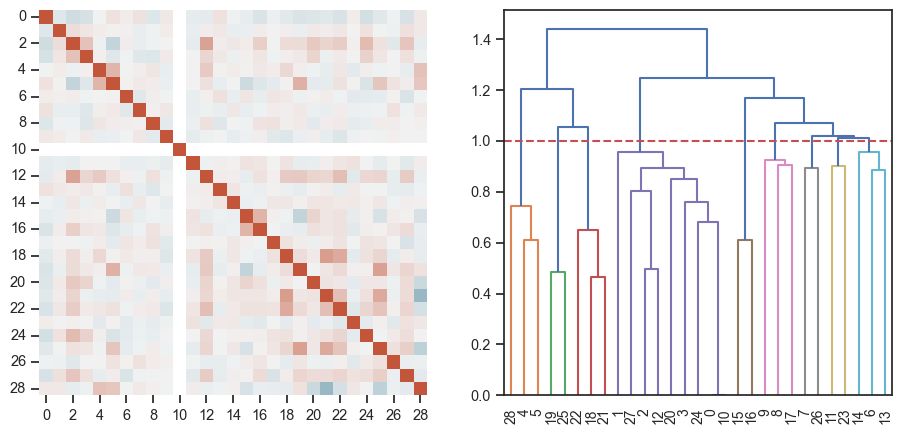

In [63]:
corr = X.corr(method = 'spearman').values

corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(pd.DataFrame(corr))
distance_matrix = distance_matrix.fillna(0)

sns.set_style('ticks')
plt.subplots(1, 2, figsize = (11, 5))

plt.subplot(1, 2, 1)
sns.heatmap(corr, cmap = sns.diverging_palette(220, 20, as_cmap=True), vmin = -1, vmax = 1, 
            linewidths = 0, cbar = False, annot = False)
plt.yticks(rotation = 0);

plt.subplot(1, 2, 2)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels = X.columns,
    leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.axhline(y=1, color='r', linestyle='--');

По дендрограмме выбираем порог и от него отбираем 1 признак для каждого кластера

Посмотрим на выбранные признаки для порога 1

In [64]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_sel = X.iloc[:,selected_features]
X_sel = X.iloc[:,selected_features]

model_rf.fit(X_sel, y)

selected_features_names = X.columns[selected_features]

print(selected_features_names.values)

['0' '4' '6' '7' '8' '11' '15' '18' '19']


Построим график значимости выбранных признаков на основе леса и график значимости перестановок

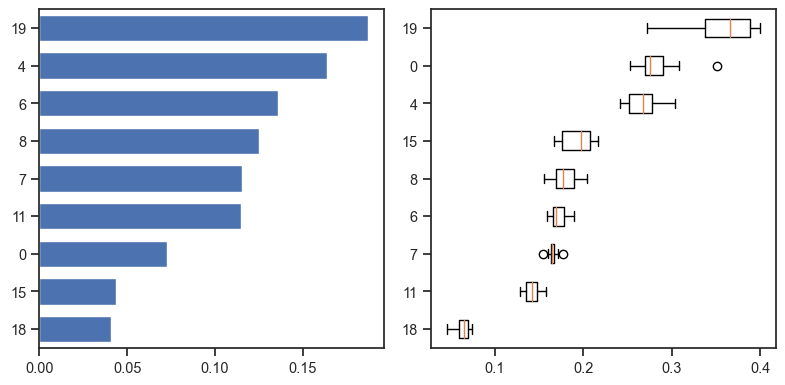

In [65]:
model_rf.fit(X_sel, y)

result = permutation_importance(model_rf, X_sel, y, n_repeats=10)

perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(model_rf.feature_importances_)
tree_indices = np.arange(0, len(model_rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.barh(tree_indices, model_rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(selected_features_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(model_rf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=selected_features_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

График до отбора

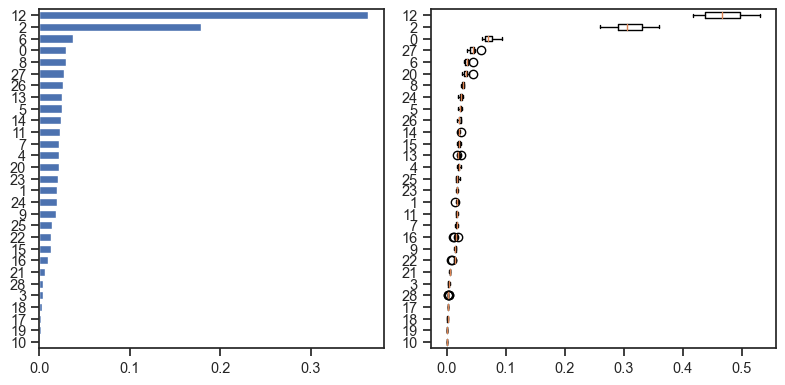

In [66]:
model_rf.fit(X, y)

result = permutation_importance(model_rf, X, y, n_repeats=10)

perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx1 = np.argsort(model_rf.feature_importances_)
tree_indices = np.arange(0, len(model_rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.barh(tree_indices, model_rf.feature_importances_[tree_importance_sorted_idx1], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx1])
ax1.set_ylim((0, len(model_rf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

До отбора были сильно значимы признаки 12 и 2. После того, как их убрали, значительно подросла значимость выбранных признаков. Скорее всего, признаки 12 и 2 мультиколлинеарны. Среди выбранных признаков, '18' возможно незначим. 

Разброс важности признаков

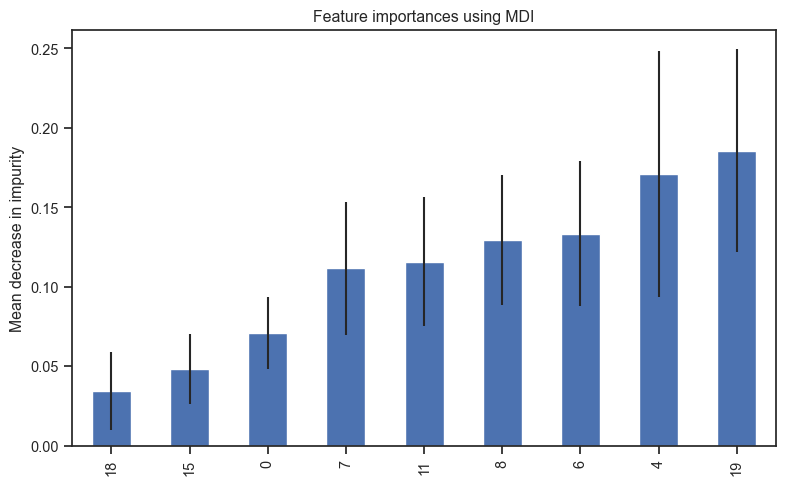

In [67]:
model_rf.fit(X_sel, y)

feature_names = selected_features_names[tree_importance_sorted_idx]
forest_importances = pd.DataFrame(model_rf.feature_importances_, 
                                  index=selected_features_names, 
                                  columns =['mean'])
forest_importances['std'] = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

sort_forest = forest_importances.sort_values(by='mean')


fig, ax = plt.subplots(figsize=(8,5))
col = sort_forest['mean']
yerr = sort_forest['std']
col.plot.bar(yerr=yerr, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Разброс важности признаков до отбора

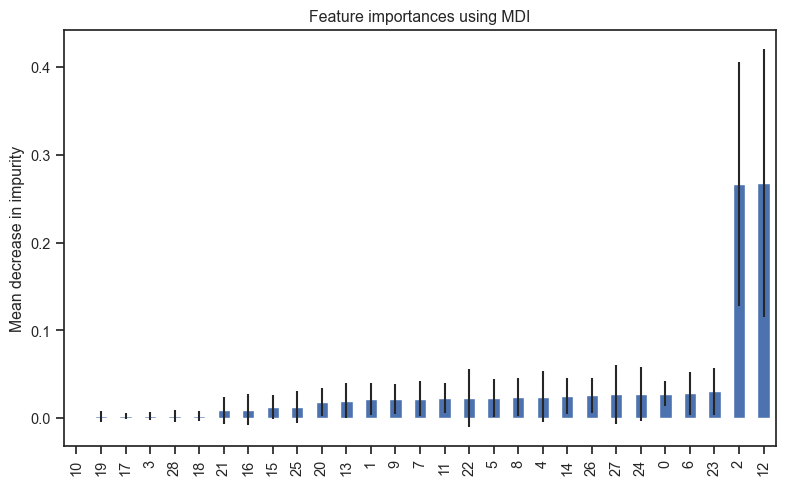

In [68]:
feature_names = X.columns
model_rf.fit(X_train, y_train)
forest_importances = pd.DataFrame(model_rf.feature_importances_, index=feature_names, columns =['mean'])
forest_importances['std'] = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

sort_forest = forest_importances.sort_values(by='mean')

fig, ax = plt.subplots(figsize=(8,5))
col = sort_forest['mean']
yerr = sort_forest['std']
col.plot.bar(yerr=yerr, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Ситуация с разбросом также улучшилась после отбора.

Итог: 0, 4, 6, 7, 8, 11, 15, 18, 19

2 и 12 мультиколлинеарны

18 значим слабо в случайном лесу

#### Рекурсивный отбор признаков

цикл пройден за 1.1 минут

oптимально : 24


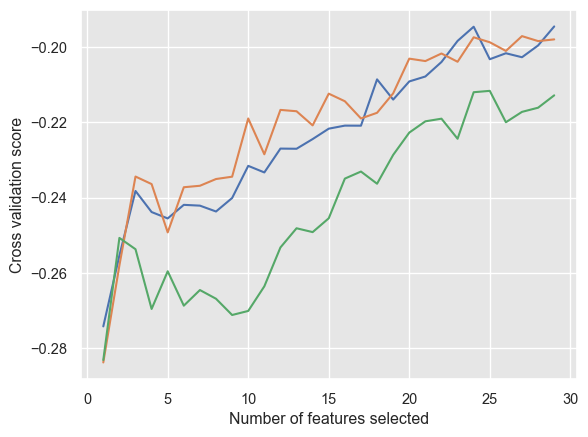

In [73]:
start = time.time()

rfecv = RFECV(
    estimator=model_rf,
    step=1,
    cv = cv,
    scoring=scoring,
    min_features_to_select=1,
)
rfecv.fit(X, y)

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
filtered = pd.DataFrame(rfecv.cv_results_).filter(regex='split')
plt.plot(range(1, len(filtered) + 1), filtered);

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")
print("\noптимально : %d" % rfecv.n_features_)

цикл пройден за 0.0 минут

oптимально : 24


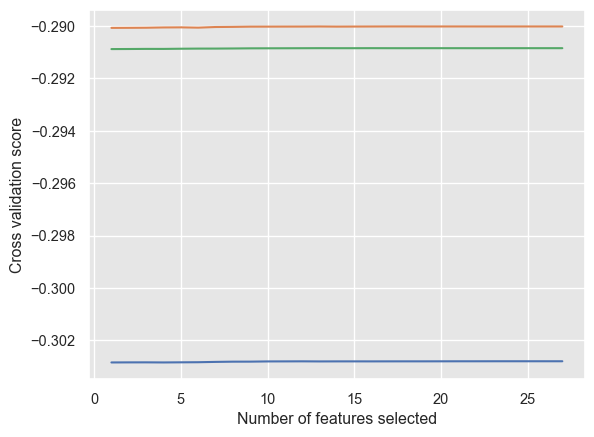

In [75]:
start = time.time()

rfecv = RFECV(
    estimator=model_svm,
    step=1,
    cv = cv,
    scoring=scoring,
    min_features_to_select=1,
)
rfecv.fit(X.drop(columns = ['2', '12']), y)

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
filtered = pd.DataFrame(rfecv.cv_results_).filter(regex='split')
plt.plot(range(1, len(filtered) + 1), filtered);

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")
print("\noптимально : %d" % rfecv.n_features_)

Добавим 20 шумовых признаков к набору данных

In [47]:
rng = np.random.RandomState(None)

noise = rng.normal(size=(len(X), 30))
X_w_noise = pd.DataFrame(np.hstack([X, noise]))

X_w_noise.head(3)

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,1.222962,0.047686,-1.033389,-2.465344,0.831065,0.802990,1.590989,0.727946,0.893957,-1.503143,...,-1.086385,1.129302,-0.512793,-0.281854,0.090620,0.770744,-0.063394,-0.723948,-0.649121,-0.129544
1,-0.091662,-0.356325,-0.486840,-2.465344,-0.126718,-0.024866,-0.323972,1.658337,1.751428,-1.573310,...,-0.266206,-0.221128,-0.407865,0.892152,-0.820219,1.758741,-0.781964,-1.049437,-0.987574,-0.513939
2,1.222962,-1.064819,0.338749,0.405623,-0.854973,-0.654330,0.525426,0.585866,-1.661101,1.007304,...,0.054802,-1.296266,0.099779,0.561157,-0.968862,-0.352991,0.130938,0.131987,-2.332677,-0.024706


цикл пройден за 3.4 минут


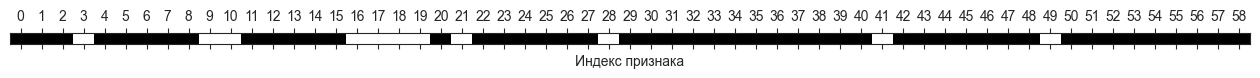

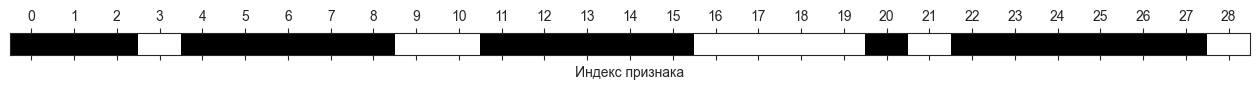

In [48]:
start = time.time()

rfecv = RFECV(
    estimator=model_rf,
    step=1,
    cv = cv,
    scoring=scoring,
    min_features_to_select=1,
)
rfecv.fit(X_w_noise, y)

mask = rfecv.get_support()
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

mask = rfecv.get_support()[:29]
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

Для случайного леса: 0, 1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 20, 22, 23, 24, 25, 26, 27

Остальные хуже шума

цикл пройден за 0.1 минут


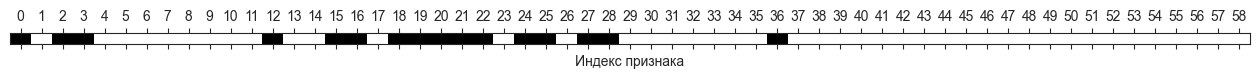

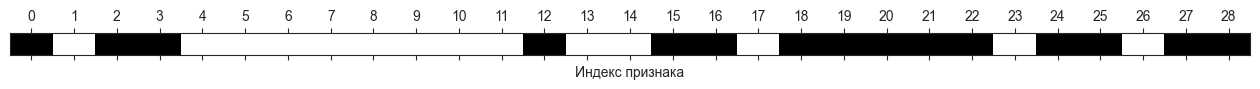

In [50]:
start = time.time()

rfecv = RFECV(
    estimator=model_svm,
    step=1,
    cv = cv,
    scoring=scoring,
    min_features_to_select=1,
)
rfecv.fit(X_w_noise, y)

mask = rfecv.get_support()
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

mask = rfecv.get_support()[:29]
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

Для машины: 0, 2, 3, 12, 15, 16, 18, 19, 20, 21, 22, 24, 25, 27, 28

Остальные хуже шума

Без кроссвалидации, выбор количества признаков с запасом

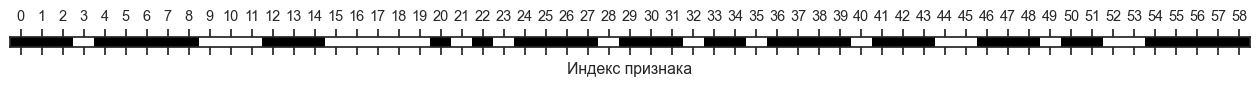

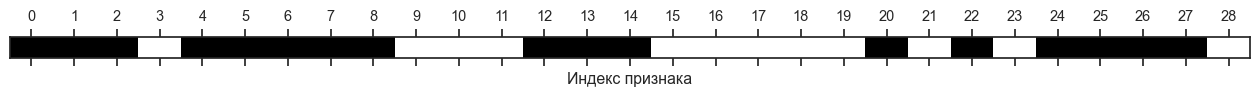

In [77]:
rfe_select = RFE(model_rf, n_features_to_select=39)

rfe_select.fit(X_w_noise, y)

mask = rfe_select.get_support()
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

mask = rfe_select.get_support()[:29]
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

Для случайного леса: 0, 1, 2, 4, 5, 6, 7, 8, 12, 13, 14, 20, 22, 24, 25, 26, 27

Остальные хуже шума

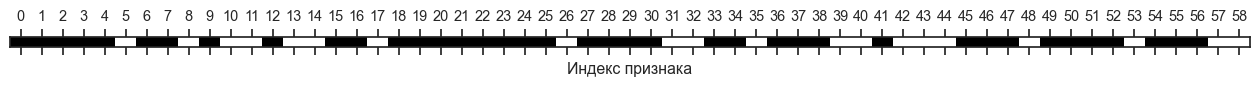

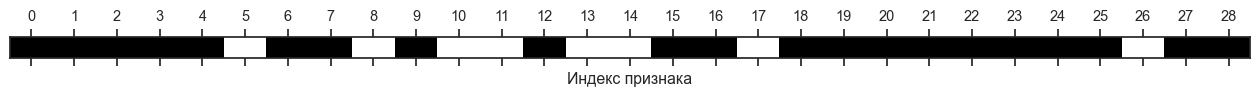

In [78]:
rfe_select = RFE(model_svm, n_features_to_select=39)

rfe_select.fit(X_w_noise, y)

mask = rfe_select.get_support()
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

mask = rfe_select.get_support()[:29]
sns.set_style('white')
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

Для машины: 0, 1, 2, 3, 4, 6, 7, 9, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28

Остальные хуже шума

По итогам рекурсивного отбора и отбора на основе модели оставим признаки, которые попали в выбор во всех трех случаях. Уберем мультиколлинеарные 2 и 12. 

Для случайного леса: 0, 1, 4, 5, 6, 8, 13, 14, 20, 22, 24, 26, 27

Для машины: 0, 3, 15, 16, 18, 19, 20, 21, 22, 24, 25, 27, 28

In [80]:
features_rf = ['0', '1', '4', '5', '6', '8', '13', '14', '20', '22', '24', '26', '27']
features_svm = ['0', '3', '15', '16', '18', '19', '20', '21', '22', '24', '25', '27', '28']

In [81]:
FunctionTransformer(lambda x: x[features_svm]).fit_transform(X_train)

,0,3,15,16,18,19,20,21,22,24,25,27,28
342,-1.406286,0.405623,-0.734539,2.149083,-0.263991,1.497407,-0.554035,0.047278,1.421812,-0.805741,1.378217,1.472618,-0.478408
108,-0.091662,-2.465344,-0.734539,-0.465315,-0.263991,-0.141322,-0.554035,0.047278,-0.570187,-0.805741,0.224410,1.472618,-0.478408
242,-1.406286,0.405623,-0.734539,-0.465315,-0.263991,-0.141322,-0.554035,-1.308863,-0.570187,-0.805741,-0.929397,-0.679063,1.307431
51,-0.091662,0.405623,1.361397,2.149083,-0.263991,-0.141322,-0.554035,0.047278,-0.570187,-0.805741,-0.929397,-0.679063,-0.478408
43,1.222962,0.405623,-0.734539,-0.465315,-0.263991,-0.141322,1.804941,0.047278,-0.570187,-0.805741,2.532024,1.472618,-0.478408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1.222962,0.405623,1.361397,-0.465315,-0.263991,-0.141322,-0.554035,0.047278,-0.570187,-0.805741,0.224410,-0.679063,-0.478408
407,-0.091662,0.405623,1.361397,-0.465315,-0.263991,-0.141322,-0.554035,0.047278,-0.570187,-0.805741,0.224410,1.472618,-0.478408
291,1.222962,0.405623,-0.734539,-0.465315,-0.263991,-0.141322,-0.554035,0.047278,-0.570187,-0.805741,0.224410,-0.679063,-0.478408
390,-0.091662,0.405623,-0.734539,-0.465315,-0.263991,-0.141322,-0.554035,1.403419,-0.570187,-0.805741,0.224410,-0.679063,-0.478408


### Подбор параметров модели

#### Машина опорных векторов

In [83]:
pipe_svm = Pipeline([('preprocessing', FunctionTransformer(lambda x: x[features_svm])),
                     ('estimator', SVR(kernel = 'linear'))])

pipe_svm.fit(X_train, y_train)

print(f"mape на проверочном наборе: {mean_absolute_percentage_error(y_test, pipe_svm.predict(X_test)):.4f}")
print("mape на кроссвалидации:",
      f'{-1*cross_val_score(pipe_svm, X_train, y_train, cv = cv, scoring = scoring).round(4)}'.replace("[", "").replace("]", "")
     )

mape на проверочном наборе: 0.2618
mape на кроссвалидации: 0.299  0.3178 0.329 


Для начала определимся с типом ядра

In [84]:
param_svm = [{'estimator__kernel': ['linear', 'rbf', 'sigmoid']},
             
             {'estimator__kernel': ['poly'], 
              'estimator__degree': [1, 2] }]

In [85]:
start = time.time()

grid_svm = GridSearchCV(pipe_svm,
                        param_svm,
                        cv = cv,
                        scoring = scoring,
                        return_train_score = True,
                        n_jobs = -1)

grid_svm.fit(X_train, y_train)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 0.0 минут


In [86]:
drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']

results_svm = pd.DataFrame(grid_svm.cv_results_).sort_values(['rank_test_score', 'std_test_score'])
results_svm.columns = results_svm.columns.str.removeprefix("param_")

display(results_svm.drop(columns = drop).T)

,0,3,2,1,4
estimator__kernel,linear,poly,sigmoid,rbf,poly
estimator__degree,NaN,1,NaN,NaN,2
split0_test_score,-0.386945,-0.386984,-0.386984,-0.386986,-0.386986
split1_test_score,-0.305132,-0.305156,-0.305156,-0.305157,-0.305157
split2_test_score,-0.315722,-0.315764,-0.315764,-0.315766,-0.315766
mean_test_score,-0.335933,-0.335968,-0.335968,-0.33597,-0.33597
std_test_score,0.036329,0.036333,0.036333,0.036333,0.036333
rank_test_score,1,2,3,4,5
split0_train_score,-0.305104,-0.305146,-0.305146,-0.305148,-0.305148
split1_train_score,-0.3174,-0.317434,-0.317435,-0.317436,-0.317436


Выбираем линейное ядро. Подберем параметры С и gamma

In [89]:
cols = np.logspace(-2, 1, 10)  #степень неучастия
rows = np.logspace(-2, 4, 10)  #степень гладкости

pipe_svm.set_params(estimator__kernel = 'linear')

start = time.time()

grid_2d_svm = [[np.mean(cross_val_score(pipe_svm.set_params(estimator__C = rows, 
                                                            estimator__gamma = cols),
                                        X_train, y_train, 
                                        cv = cv,
                                        scoring = scoring,
                                        n_jobs = -1))
                for cols in cols] 
               for rows in rows]

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

grid_2d_svm = pd.DataFrame(grid_2d_svm, columns = cols.round(2), index = rows.round(2))

цикл пройден за 0.1 минут


максимум в точке (10000.0, 0.1)



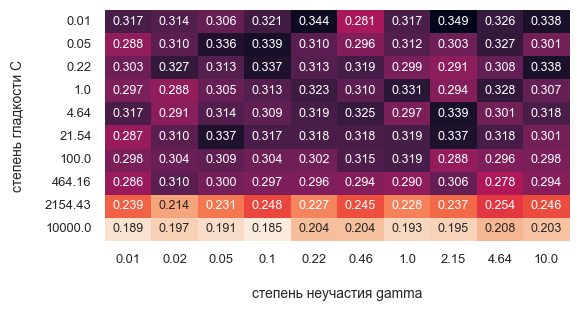

In [90]:
sns.set_theme(font_scale = 0.85)
sns.set_style('white')

plt.subplots(figsize = (6, 3))

sns.heatmap(-1*grid_2d_svm, cmap = 'rocket_r', cbar = False, linewidths = 0,
            annot = True, fmt = '.3f', annot_kws = {'fontsize': 9, 'rotation': 'horizontal'})

plt.yticks(rotation = 0)
plt.xlabel("степень неучастия gamma", labelpad = 15, fontsize = 10)
plt.ylabel("степень гладкости C", labelpad = 15, fontsize = 10)

rmax = grid_2d_svm.index.tolist()[grid_2d_svm.max(axis = 1).argmax()]
cmax = grid_2d_svm.columns.tolist()[grid_2d_svm.iloc[grid_2d_svm.max(axis = 1).argmax()].argmax()]

print(f"максимум в точке ({rmax}, {cmax})\n")

Остановимся на C = 10000 и gamma = 0.1.

In [91]:
pipe_SVM = Pipeline([('preprocessing', FunctionTransformer(lambda x: x[features_svm])),
                     ('estimator', SVR(kernel = 'linear', C = 10000, gamma = 0.1))])

pipe_SVM.fit(X_train, y_train)

print(f"mape на проверочном наборе: {mean_absolute_percentage_error(y_test, pipe_SVM.predict(X_test)):.4f}")
print("mape на кроссвалидации:",
      f'{-1*cross_val_score(pipe_SVM, X_train, y_train, cv = cv, scoring = scoring).round(4)}'.replace("[", "").replace("]", "")
     )

mape на проверочном наборе: 0.1610
mape на кроссвалидации: 0.2161 0.2163 0.2036


#### Случайный лес

In [93]:
pipe_rf = Pipeline([('preprocessing', FunctionTransformer(lambda x: x[features_rf])),
                    ('estimator', RandomForestRegressor(n_jobs = -1))])

pipe_rf.fit(X_train, y_train)

print(f"mape на проверочном наборе: {mean_absolute_percentage_error(y_test, pipe_rf.predict(X_test)):.4f}")
print("mape на кроссвалидации:",
      f'{-1*cross_val_score(pipe_rf, X_train, y_train, cv = cv, scoring = scoring).round(4)}'.replace("[", "").replace("]", ""))

mape на проверочном наборе: 0.2025
mape на кроссвалидации: 0.2472 0.2142 0.2229


Определим количество деревьев

In [94]:
#функция для определения количества деревьев

def trees(model, score = scoring, criterion = ['gini', 'entropy'], trees = range(15, 3000, 10), random_state = None):
    
    start = time.time()
    
    model['estimator'].set_params(oob_score = eval(f"{score}"), random_state = random_state, n_jobs = -1)
    
    scores = pd.DataFrame(columns = [f'{c} {s}' for c in criterion for s in ['train', 'test', 'OOB']], index = trees)

    for c in criterion:
        for i in trees: 
            warm = False if i == trees[0] else True #иначе теплый старт не работает

            model['estimator'].set_params(n_estimators = i, criterion = c, warm_start = warm)
            model.fit(X_train, y_train)

            scores[f'{c} train'][i] = eval(f"{score}")(y_train, model.predict(X_train))
            scores[f'{c} test'][i] = eval(f"{score}")(y_test, model.predict(X_test))
            scores[f'{c} OOB'][i] = model['estimator'].oob_score_
    
    sns.set_theme(font_scale = 0.85)
    sns.set_style('darkgrid', {'axes.facecolor': '.91'})

    plt.subplots(1, len(criterion), figsize = (8 if len(criterion) == 2 else 5, 3), sharey = True)
    plt.subplots_adjust(wspace = 0.1)
    
    for i in range(1, len(criterion) + 1):
        
        plt.subplot(1, len(criterion), i)

        plt.plot(scores[f'{criterion[i-1]} train'], label = "score тренировочный", color = 'b', linewidth = 1.2)
        plt.plot(scores[f'{criterion[i-1]} test'], label = "score тестовый", color = 'r', linewidth = 1.2)
        plt.plot(scores[f'{criterion[i-1]} OOB'], label = "score OOB", color = 'r', linewidth = 1.2, linestyle = ':')

        plt.title(f"критерий {criterion[i-1]}", pad = 15, fontsize = 11, fontweight = 'bold')
        plt.xlabel("количество деревьев", labelpad = 15)
        if i == 1: plt.ylabel(f"{score} score", labelpad = 15)
    
    plt.legend(loc = 'upper left', bbox_to_anchor = (1.05, 0, 1.1, 1), framealpha = 0)
        
    print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 1.6 минут


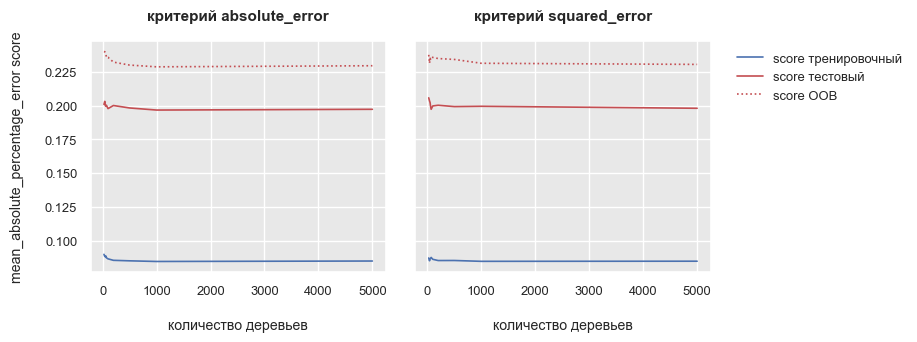

In [95]:
trees(pipe_rf, score = 'mean_absolute_percentage_error', criterion = ['absolute_error', 'squared_error'],
      trees = [25, 40, 50, 60, 70, 100, 200, 500, 1000, 5000])

Количество деревьев нужно брать от 1000. Критерий absolute_error лучше.

In [96]:
pipe_rf.set_params(estimator__n_estimators = 1000, estimator__criterion = 'absolute_error');

Подберем остальные параметры

In [97]:
#функция для графиков зависимостей между параметрами случайного леса

def forest_parameter(model, 
                     param, options,        #имя интересующего параметра и его значения
                     param_x, options_x,    #имя параметра по оси х и его значения
                     param_dict = {},       #словарь стационарных параметров
                     warm_start = False,    #нужен, если по оси х деревья
                     score = scoring,
                     test_score = False,    #нужен ли график метрики по проверочному набору
                     oob_score = True,       
                     color = sns.color_palette()[3:7],
                     alpha = 0.7):
    
    start = time.time()

    memory = model.get_params() #запомнить исходные параметры
    
    if oob_score == True: model.set_params(**{'estimator__oob_score': eval(f"{score}")} | param_dict)
        
    table_oob = pd.DataFrame(columns = options, index = options_x)
    table_test = pd.DataFrame(columns = options, index = options_x)

    for option in options:
        for i in options_x:

            if warm_start == True:
                warm = False if i == options_x[0] else True
            else:
                warm = False

            model.set_params(**{param_x: i, param: option, 'estimator__warm_start': warm})
            model.fit(X_train, y_train)

            if oob_score == True: table_oob.loc[i, option] = model['estimator'].oob_score_
            if test_score == True: table_test.loc[i, option] = eval(f"{score}")(y_test, model.predict(X_test))
            
    model.set_params(**memory) #вернуть исходные параметры        
            
    sns.set_theme(font_scale = 0.85)
    sns.set_style('darkgrid', {'axes.facecolor': '.91'})

    plt.subplots(figsize = (9, 4))

    if oob_score + test_score == 2:
        for option in options:
            
            plt.plot(table_oob[option], label = str(option) + " OOB", 
                     color = color[options.index(option)], alpha = alpha)

            plt.plot(table_test[option], label = str(option) + " test", 
                     color = color[options.index(option)], alpha = alpha, linestyle = ':')

        plt.ylabel(f"{score}", labelpad = 15)
    else:
        for option in options:

            plt.plot(eval(f'table_{"oob" if oob_score == True else "test"}')[option], label = str(option), 
                     color = color[options.index(option)], alpha = alpha)

        plt.ylabel(f'{score} на {"OOB" if oob_score == True else "тесте"}', labelpad = 15)

    plt.title("параметр " + eval("param.removeprefix('estimator__')"), pad = 35, fontsize = 11, fontweight = 'bold')
    plt.xlabel(eval("param_x.removeprefix('estimator__')"), labelpad = 15)
    plt.legend(ncol = len(options)*(2 if oob_score + test_score == 2 else 1), 
               loc = 'upper center', bbox_to_anchor = (0, 0, 1, 1.12), framealpha = 0)

    print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 1.2 минут


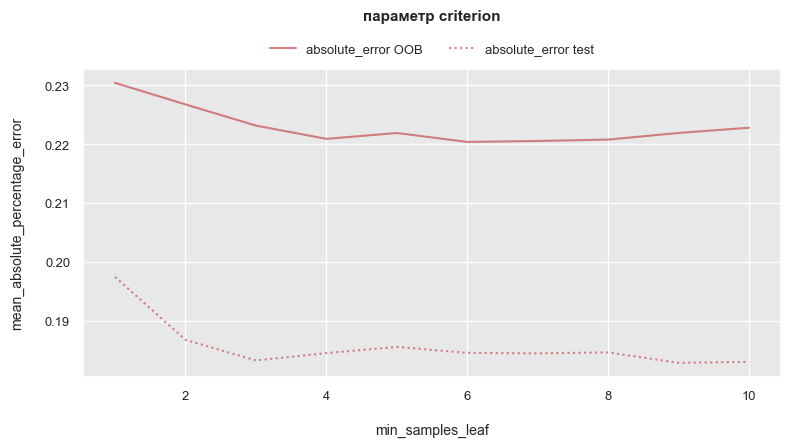

In [99]:
forest_parameter(pipe_rf, 'estimator__criterion', ['absolute_error'],
                          'estimator__min_samples_leaf', range(1, 11),
                 
                           test_score = True, oob_score = True,
                           score = 'mean_absolute_percentage_error')

Выберем min_samples_leaf = 6

цикл пройден за 1.3 минут


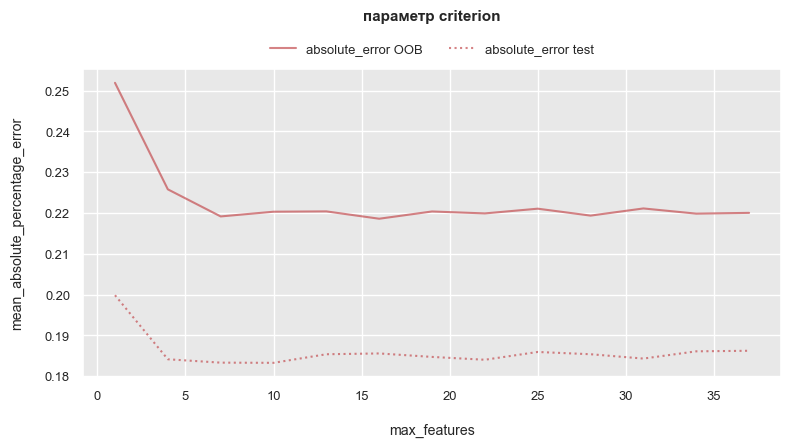

In [100]:
forest_parameter(pipe_rf, 'estimator__criterion', ['absolute_error'],
                          'estimator__max_features', range(1, 40, 3),
                          
                           param_dict = {'estimator__min_samples_leaf': 6},
                           test_score = True, oob_score = True,
                           score = 'mean_absolute_percentage_error')

Выберем max_features = 16

In [101]:
pipe_RF = Pipeline([('preprocessing', FunctionTransformer(lambda x: x[features_rf])),
                    ('estimator', RandomForestRegressor(n_estimators = 1000, criterion = 'absolute_error',
                                                        min_samples_leaf = 6, max_features = 16,
                                                        n_jobs = -1))])

pipe_RF.fit(X_train, y_train)

print(f"mape на проверочном наборе: {mean_absolute_percentage_error(y_test, pipe_RF.predict(X_test)):.4f}")
print("mape на кроссвалидации:",
      f'{-1*cross_val_score(pipe_RF, X_train, y_train, cv = cv, scoring = scoring).round(4)}'.replace("[", "").replace("]", ""))

mape на проверочном наборе: 0.1838
mape на кроссвалидации: 0.2009 0.2397 0.2288


признаки с важностью менее 0.01:




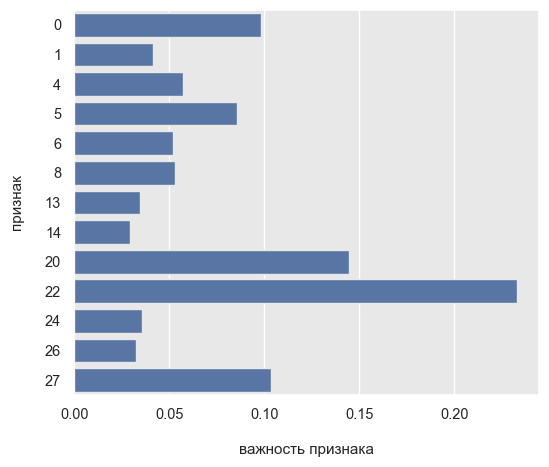

In [102]:
feature_importance(pipe_RF['estimator'], limit = 0.01, color = 'b')

### Сравнение моделей

In [103]:
pipes = ['SVM', 'RF']

In [104]:
for i in pipes:
    exec(f"y_predict_{i} = pipe_{i}.predict(X_test)")

#### 1 Тестовые метрики 

In [105]:
for i in pipes:
    print(f"model {i} test MAPE: {mean_absolute_percentage_error(y_test, eval(f'y_predict_{i}')):.4f}")

model SVM test MAPE: 0.1610
model RF test MAPE: 0.1838


In [106]:
start = time.time()

table = pd.DataFrame(columns = pipes)

for i in pipes:
    table[i] = cross_val_score(eval(f"pipe_{i}"), X, y, scoring = scoring,
                               cv = ShuffleSplit(n_splits = 5, test_size = 0.3))
    
print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 0.5 минут


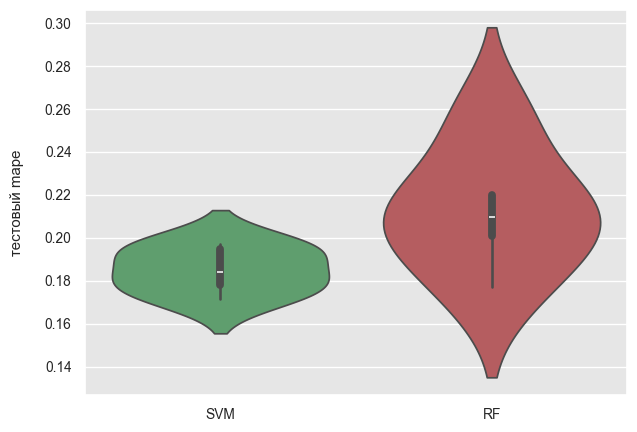

In [107]:
sns.set_theme(font_scale = 0.9)
sns.set_style('darkgrid', {'axes.facecolor': '.9'})

plt.figure(figsize = (7, 5))
plt.ylabel(f"тестовый mape", labelpad = 15)

sns.violinplot(data = -1*table, palette = sns.color_palette()[2:4]);                              

#### 2 Графики предсказанных значений и остатков 

Max Error: 1


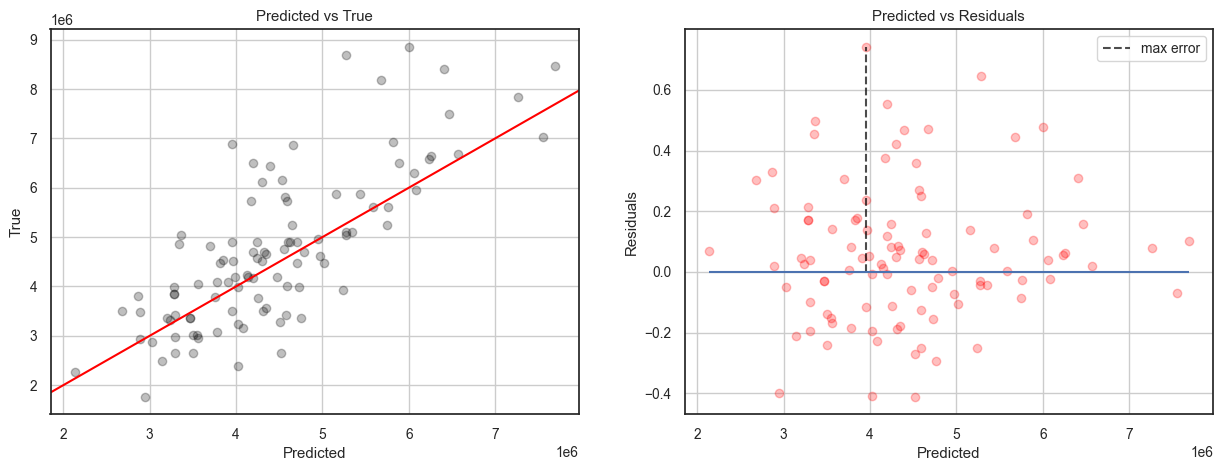

In [108]:
plot_2_error(y_test, pipe_SVM.predict(X_test))

Max Error: 1


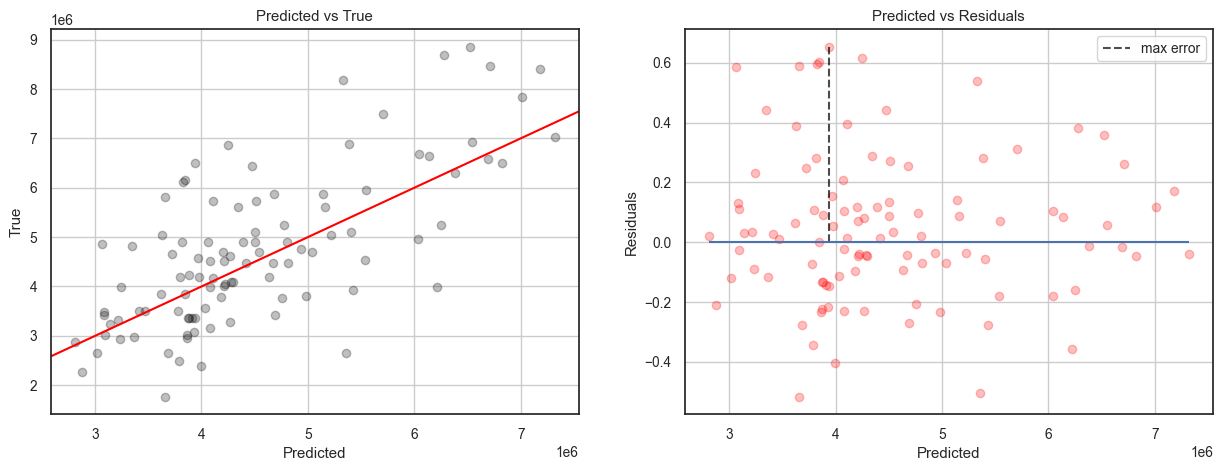

In [109]:
plot_2_error(y_test, pipe_RF.predict(X_test))

По выбранной метрике лучший результат на проверочном наборе дает модель SVM, она же является более стабильной при кроссвалидационной проверке. Остановимся на ней. 

### Лучшая модель

In [115]:
X = data.drop(columns = ['price'])
y = data.loc[:,'price'].values

In [116]:
features = ['0', '3', '15', '16', '18', '19', '20', '21', '22', '24', '25', '27', '28']

In [117]:
pipe_final = make_pipeline(FunctionTransformer(lambda x: x[features]),
                           SVR(kernel = 'linear', C = 10000, gamma = 0.1))

pipe_final.fit(X, y)

print(f"mape на всем наборе данных: {mean_absolute_percentage_error(y, pipe_final.predict(X)):.4f}\n")

mape на всем наборе данных: 0.1823

